# Links to Datasets:

In [1]:
PATH_EIVP_DATASET_MESURES = "../data/EIVP_DATASET_MESURES.xlsx"
PATH_METEO = "../data/donnees-synop-essentielles-omm.xlsx"

# Main imports

In [ ]:
%pip install openpyxl

In [8]:
# ----------------------------------- Utils ---------------------------------- #
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

# ------------------------------- Data Analysis ------------------------------ #
import pandas as pd

# --------------------------- Prediction utils libs -------------------------- #
import autosklearn.regression

# --------------------------------- eval libs -------------------------------- #
import sklearn.metrics

# Load and create Dataset

prepare EIVP data

In [9]:
# ----------------------------------- load ----------------------------------- #
eivp = pd.read_excel(PATH_EIVP_DATASET_MESURES)
# ----------------------------- imp columns opnly ---------------------------- #
columns_of_interest_eivp=[
    "humidity",
    "lum",
    "temp",
    "co2",
    # "hpa",
    "sent_at",
]
eivp = eivp[columns_of_interest_eivp]
# ------------------------------ set date column ----------------------------- #
eivp['sent_at'] = pd.to_datetime(eivp['sent_at'])
eivp = eivp.rename(columns={'sent_at': 'Date'}) # rename column to Date
eivp = eivp.set_index('Date')
# --------------------------------- Resample --------------------------------- #
eivp = eivp.resample('3H', origin=datetime.strptime('2021-04-13 17:00:00', "%Y-%m-%d %H:%M:%S")).mean()

prepare Meteo data

In [10]:
# ----------------------------------- load ----------------------------------- #
meteo = pd.read_excel(PATH_METEO)
# ------------------------- filter important columns ------------------------- #
columns_of_interest_meteo=[
    "Date",
    # "Pression au niveau mer",
    "Direction du vent moyen 10 mn",
    "Vitesse du vent moyen 10 mn",
    # "TempÃ©rature",
    "HumiditÃ©",
    "Pression station",
    "TempÃ©rature (Â°C)",
]
meteo = meteo[columns_of_interest_meteo]
# ------------------------------ set date column ----------------------------- #
meteo["Date"] = pd.to_datetime(meteo["Date"])
meteo['Date'] = meteo['Date'].dt.tz_localize(None)

Merge data

In [11]:
data = eivp.merge(meteo, on='Date')

# Split data

It is important to split the data using the date to guarantee no Bias in any of the models. The dimensionality of the data is high (in comparission to its length) and the models might overfit to the data points.

Lets say we take 80% of the data for training and 20% for testing.

In [12]:
train_ratio = 0.8
l_train = int(len(data)*train_ratio)
train, test = data[:l_train], data[l_train:]

# Shallow approach

- In this shallow approach, there will be no consideration for :
    - Sequentiality of data
    - Time-series nature of data
        - Problem will be treated as a tabular data with no date information 
    

In [13]:
target = ['temp']

In [14]:
x_train, y_train = train.drop(columns=target + ["Date"]).to_numpy(), train[target].to_numpy()
x_test, y_test = test.drop(columns=target + ["Date"]).to_numpy(), test[target].to_numpy()

Using Auto ML

In [31]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=1200, # 20 minutes
    per_run_time_limit=30,
    tmp_folder='../tmp/autosklearn_regression_example_tmp',
)
automl.fit(x_train, y_train, dataset_name='EIVP Temperature')

/home/mus5900/anaconda3/envs/machine_learning/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/mus5900/anaconda3/envs/machine_learning/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=1200,
                     tmp_folder='../tmp/autosklearn_regression_example_tmp')

In [32]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost  duration
model_id                                                              
362          1             0.02                sgd  0.133228  0.436981
151          2             0.40                sgd  0.133799  0.427536
8            3             0.26  gradient_boosting  0.151134  0.832347
3            4             0.32   gaussian_process  0.154624  0.782750


In [33]:
pprint(automl.show_models(), indent=4)

{   3: {   'cost': 0.15462383814903236,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f847acbfb20>,
           'ensemble_weight': 0.32,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f84355bd160>,
           'model_id': 3,
           'rank': 4,
           'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f84355bdb80>,
           'sklearn_regressor': GaussianProcessRegressor(alpha=0.037731974209709904,
                         kernel=RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=1)},
    8: {   'cost': 0.15113398220562424,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataP

In [34]:
train_predictions = automl.predict(x_train)
print("Train :")
print("\t R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
print("\t MAE:", sklearn.metrics.mean_absolute_error(y_train, train_predictions))
print("\t RMSE:", sklearn.metrics.mean_squared_error(y_train, train_predictions))
test_predictions = automl.predict(x_test)
print("Test :")
print("\t R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))
print("\t MAE:", sklearn.metrics.mean_absolute_error(y_test, test_predictions))
print("\t RMSE:", sklearn.metrics.mean_squared_error(y_test, test_predictions))

Train :
	 R2 score: 0.9360267738497742
	 MAE: 0.2775267697400366
	 RMSE: 0.1301828479808267
Test :
	 R2 score: 0.010727608804410371
	 MAE: 1.1704231293439264
	 RMSE: 2.2474090269848133


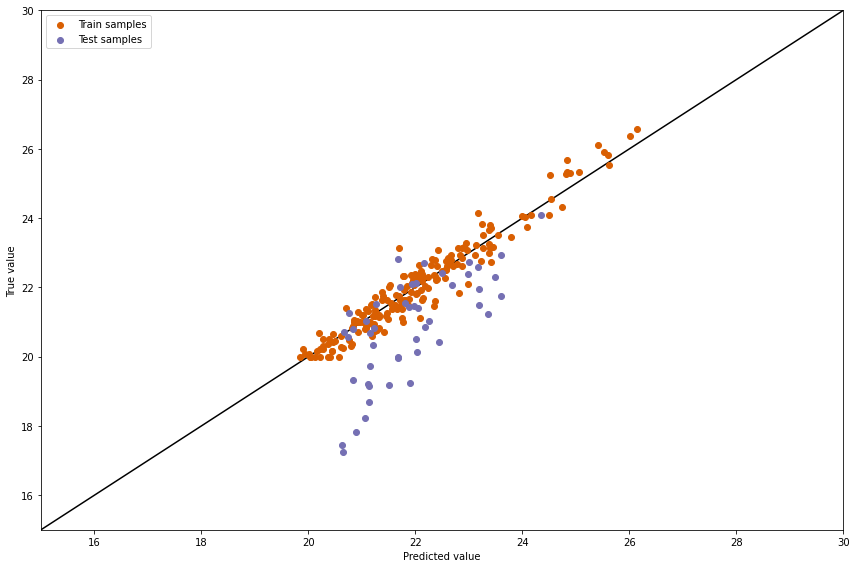

In [35]:
plt.figure(figsize=(12, 8))
plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02')
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3')
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([15, 30], [15, 30], c='k', zorder=0)
plt.xlim([15, 30])
plt.ylim([15, 30])
plt.tight_layout()
plt.show()